In [1]:
import os
import codecs
import pandas as pd

# change dir for custom imports
os.chdir('../')
from scripts.dataset_downloader import initialize_dataset
from scripts.k_means import create_clsuters, clustering_errors
from scripts.helpers import get_most_rated_movies


dataset = 'ml-100k'
dataset_path = os.path.join('datasets', dataset)

In [ ]:
# If dataset hasn't been previously initialized, it can be done with this function
initialize_dataset(dataset)

In [2]:
ratings_path = os.path.join(dataset_path, 'u.data')
items_path = os.path.join(dataset_path, 'u.item')
genres_path = os.path.join(dataset_path, 'u.genre')
ratings_file = codecs.open(ratings_path, 'rU', 'UTF-8')
items_file = codecs.open(items_path, 'rU', 'latin-1')

# load data
ratings_df = pd.read_csv(ratings_file, sep='\t', names=('user_id', 'item_id', 'rating', 'timestamp'))
genres_df = pd.read_csv(genres_path, sep='|', names=('title', 'id'))
cols_names = ('id', 'title', 'year', 'nan', 'link') + tuple(genres_df.title.to_list())
items_df = pd.read_csv(items_file, sep='|', usecols=list(range(0,24)), names=cols_names).drop(columns=['nan', 'link'])

# dataset stats
print(f"Total dataset users: {len(set(ratings_df.user_id.to_list()))}")
print(f"Total dataset ratings: {len(ratings_df.user_id.to_list())}")

Total dataset users: 943
Total dataset ratings: 100000


In [3]:
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings_df, items_df[['id', 'title']], left_on='item_id', right_on='id').drop(columns=['id'])
user_movie_ratings = pd.pivot_table(ratings_title, index='user_id', columns= 'title', values='rating')

# print the number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (943, 1664) 

Subset example:


title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)"
user_id,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN
6,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN


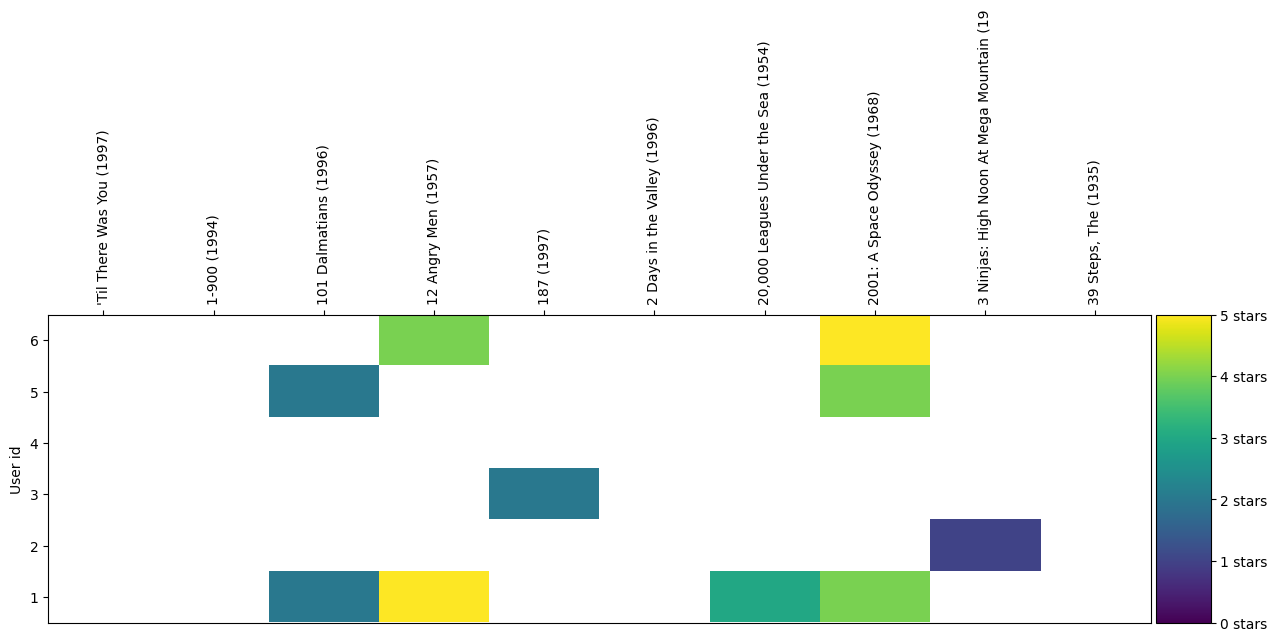

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')
    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

plt.show()
# Print the heatmap
draw_movies_heatmap(user_movie_ratings.iloc[:6, :10])

In [6]:
user_movie_ratings = pd.DataFrame(user_movie_ratings).fillna(0)

In [7]:
from scipy.sparse import csr_matrix
import scipy

# Conversion to sparse csr matrix
# sparse_ratings = csr_matrix(pd.SparseDataFrame(user_movie_ratings).to_coo())
sparse_ratings = scipy.sparse.csr_matrix(user_movie_ratings.values)
sparse_ratings

<943x1664 sparse matrix of type '<class 'numpy.float64'>'
	with 99693 stored elements in Compressed Sparse Row format>

In [9]:
from sklearn.cluster import KMeans

# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

In [10]:
# cluster and print some of them
clustered = pd.concat([user_movie_ratings.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

In [ ]:
clustered.head()

In [12]:
group_df = clustered.copy()
group_matrix = scipy.sparse.csr_matrix(group_df.values)
group_cluster_preds = KMeans(n_clusters=10, algorithm='full').fit_predict(group_matrix)
group_clusters = pd.concat([group_df.reset_index(), pd.DataFrame({'group_group':group_cluster_preds})], axis=1)

In [ ]:
clustered.to_csv('./output/exp-1/clusters.csv', index=False)

In [14]:
group_clusters.to_csv('group_clusters.csv')